In [1]:
import numpy as np
import pandas as pd
from utils import misc
from utils.misc import get_attr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from new_agent import DQNagent
from new_env import TradingEnv
from new_trainer import Trainer

import optuna

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


pd.set_option('mode.chained_assignment', None)

In [2]:
# df = misc.get_price_data('SPY')
# # df = misc.clean_df(df)
# df.to_csv('datasets/price_series/SPY.csv')

In [3]:
spy_df = pd.read_csv('datasets/price_series/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.029366,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.207397,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.260799,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.527802,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.634630,531500,SPY
...,...,...,...,...,...,...,...,...
7679,2023-07-31,457.410004,458.160004,456.049988,457.790009,457.790009,62040400,SPY
7680,2023-08-01,456.269989,457.250000,455.489990,456.480011,456.480011,55291500,SPY
7681,2023-08-02,453.250000,453.519989,449.350006,450.130005,450.130005,93933400,SPY
7682,2023-08-03,448.040009,450.790009,447.369995,448.839996,448.839996,64276100,SPY


In [4]:
df = spy_df.copy()

# generate moving average technical indicator
col_names = []
for i in range(3, 21):
    col_name = 'ma' + str(i)
    df[col_name] = df['close'].rolling(i).mean()
    col_names.append(col_name)

df['returns'] = np.insert(df['close'].to_numpy()[1:] / df['close'].to_numpy()[:-1], 1, 0) - 1
df['volatility'] = df['returns'].rolling(30).std()

df = df.dropna()

In [5]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

In [6]:
input_feature_list = [
    'open',
    'high',
    'low',
    'close',
    'adjclose',
    'volume',
    'volatility',
]

input_feature_list += col_names

trader_state_list = [
    'cash',
    'position',
    'position_value',
    'portfolio_value',
    # 'leverage',
    # 'portfolio_volatility',
]

params = {
    # agent params
    'action_size': 9,
    'state_size': len(input_feature_list) + len(trader_state_list),
    'epsilon': 1.0,
    'epsilon_decay': 0.9995,
    'epsilon_min': 0.01,
    'replay_memory_size': 100000,
    'batch_size': 200,
    'gamma': 0.99,
    'new_model': True,
    'save_model_path': 'dqn.pth',
    'load_model_path': 'dqn.pth',
    # env_params
    'initial_capital': 1000000,
    'hindsight_weight': 0.5,
    'lookback_period': 20,
    'lookforward_period': 20,
    'render_window_size': 10,
    'input_feature_list': input_feature_list,
    'trader_state_list': trader_state_list,
    'is_discrete': True,
    # trainer_params
    'num_episodes': 20,
    'record_var_list': ['portfolio_return'],
    'learning_rate': 0.001,
    'target_update_threshold': 10,
}

train_df = df[-500:-100]
test_df = df[-100:]

train_env = TradingEnv(df=train_df, **params)
test_env = TradingEnv(df=test_df, **params)

agent = DQNagent(DQN, **params)

['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']
['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']


c:\Users\alexr\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\alexr\trading_with_reinforcement_learning\new_agent.py:136: UserWarning: Using a target size (torch.Size([200, 200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(current_q_values, expected_q_values)


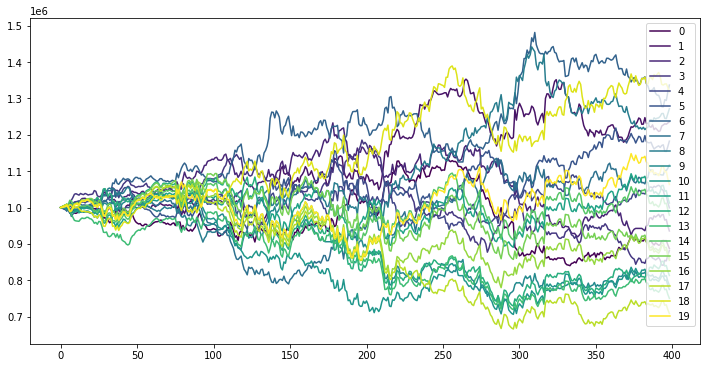

In [7]:
trainer = Trainer(agent=agent, **params)

record = trainer.train(train_df)

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 20))



for r in range(len(record)):
    plt.plot(record[r]['portfolio_value'], label=r, color=colors[r])

plt.legend()
plt.show()

In [11]:
obj_agent = DQNagent(DQN, **params)
obj_trainer = Trainer(obj_agent, **params)
obj_trainer.train(train_df)
obj_env = obj_trainer.test(test_df)

plt.plot(obj_env.record['portfolio_value'], label=r, color=colors[r])

plt.legend()
plt.show()

# Compute the validation loss
# score = obj_env.sharpe

['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']


c:\Users\alexr\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\alexr\trading_with_reinforcement_learning\new_agent.py:136: UserWarning: Using a target size (torch.Size([200, 200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(current_q_values, expected_q_values)


['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']


AttributeError: 'TradingEnv' object has no attribute 'record'

In [9]:
# Define the objective function to be optimized by Optuna
def objective(trial):
    params = {
        # agent params
        'action_size': 9,
        'state_size': len(input_feature_list) + len(trader_state_list),
        'epsilon': 1.0,
        'epsilon_decay': trial.suggest_float('epsilon_decay', 0.8, 0.9995),
        'epsilon_min': trial.suggest_float('epsilon_min', 0.005, 0.05),
        'replay_memory_size': trial.suggest_int('replay_memory_size', 1000, 100000),
        'batch_size': trial.suggest_int('batch_size', 100, 1000),
        'gamma': trial.suggest_float('gamma', 0.01, 0.99),
        'new_model': True,
        'save_model_path': 'dqn.pth',
        'load_model_path': 'dqn.pth',
        # env_params
        'initial_capital': 1000000,
        'hindsight_weight': trial.suggest_float('hindsight_weight', 0.1, 1.0),
        'lookback_period': 20,
        'lookforward_period': 20,
        'render_window_size': 10,
        'input_feature_list': input_feature_list,
        # trainer_params
        'num_episodes': 10,
        'record_var_list': ['portfolio_return'],
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.1),
        'target_update_threshold': 9,
    }

    # Train the model using the current set of hyperparameters
    obj_agent = DQNagent(DQN, **params)
    obj_trainer = Trainer(obj_agent, **params)
    obj_trainer.train(train_df)
    obj_env = obj_trainer.test(test_df)

    # Compute the validation loss
    score = obj_env.sharpe

    return score

# Create the Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2023-08-05 15:57:36,261] A new study created in memory with name: no-name-de30ba9c-e30b-449b-9ab9-f4e690e3208a
[W 2023-08-05 15:57:36,271] Trial 0 failed with parameters: {'epsilon_decay': 0.9240654216396139, 'epsilon_min': 0.04840797145419584, 'replay_memory_size': 86575, 'batch_size': 934, 'gamma': 0.7216315508541569, 'hindsight_weight': 0.5207089022228703, 'learning_rate': 0.011602762116656302} because of the following error: TypeError("object of type 'NoneType' has no len()").
Traceback (most recent call last):
  File "c:\Users\alexr\AppData\Local\Programs\Python\Python38\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-9-13153febc576>", line 33, in objective
    obj_trainer.train(train_df)
  File "c:\Users\alexr\trading_with_reinforcement_learning\new_trainer.py", line 24, in train
    self.env = TradingEnv(df = df, **self.params)
  File "c:\Users\alexr\trading_with_reinforcement_learning\new_env.py",

['open', 'high', 'low', 'close', 'adjclose', 'volume', 'volatility', 'ma3', 'ma4', 'ma5', 'ma6', 'ma7', 'ma8', 'ma9', 'ma10', 'ma11', 'ma12', 'ma13', 'ma14', 'ma15', 'ma16', 'ma17', 'ma18', 'ma19', 'ma20']


TypeError: object of type 'NoneType' has no len()

In [ ]:
# Print the best set of hyperparameters
print(f'Best trial: {study.best_trial.params}')

Best trial: {'epsilon_decay': 0.8306813359067265, 'epsilon_min': 0.01444127970152943, 'replay_memory_size': 19639, 'batch_size': 571, 'gamma': 0.631254580290752, 'hindsight_weight': 0.6764271893051359, 'learning_rate': 0.011191048800987747}


In [ ]:
best_trial = {
    'epsilon_decay': 0.8306813359067265, 
    'epsilon_min': 0.01444127970152943, 
    'replay_memory_size': 19639, 
    'batch_size': 571, 
    'gamma': 0.631254580290752, 
    'hindsight_weight': 0.6764271893051359, 
    'learning_rate': 0.011191048800987747
}